In [146]:
# import packages
import numpy as np
import pandas as pd
import math
import itertools

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays


from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf

import xgboost as xgb


XGBoost, short for Extreme Gradient Boosting, is a powerful and versatile machine learning algorithm that belongs to the gradient boosting family. XGBoost builds an ensemble of decision trees sequentially, with each subsequent tree correcting errors made by the previous ones. It incorporates regularization techniques, parallel processing, and efficient algorithms to optimize training speed and enhance predictive accuracy.
- Same as before, I scaled the data. For the development of the XGBoost model, I created two datasets—one grouped by date and one ungrouped. I did this because, for all my previous models, I used grouped data and wanted to investigate which dataset would yield better XGBoost performance.



In [155]:
import warnings

# Suppress specific warning types
warnings.filterwarnings("ignore")

pred_var = 'Additional_Doses_Vax_Pct'

df = pd.read_csv('df_post_eda.csv')

# group data by Date
df['Date'] = pd.to_datetime(df['Date'])
df = df.groupby('Date').mean()

#subset data to be only dates and predicting variable values
data = pd.DataFrame(df)

# resambpling to weekly datetime to prevent convergence warnings
data_w = data.resample('W').sum()

#scaling data
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
data = pd.DataFrame(min_max_scaler.fit_transform(data_w), columns=data.columns, index=data_w.index)
data = data.reset_index()
data = data.sort_values(by ='Date',ascending=True)

The data set had over 80 variables, to see if i could narrow down the number of selectors further I used Spearman correlation. I used this method as it checks for correlation but does not assume linear relationship unlike other correlation metrics. This was necessary as I knew many of my variables were not normally distributed. I decided to move forward with all variables that had correlation greater than 0.8 with the prediction variable. I found that to be a good threshold that allowed me to keep a majority of strongly correlated variables. This left me with 59 features.

In [157]:
from scipy.stats import spearmanr

df = data.copy()

# Exclude 'date' column from correlation calculation
numeric_columns = df.select_dtypes(include=['float64']).columns
correlations = df[numeric_columns].apply(lambda x: spearmanr(x, df[pred_var]).correlation)

# Rank features based on absolute correlation values
ranked_features = correlations.abs().sort_values(ascending=False)

# Filter columns with correlation >= 0.8
selected_features = correlations[correlations.abs() >= 0.8].index.tolist()
#print("Selected Features:", selected_features)

selected_features_pred = selected_features + [pred_var,'Date']


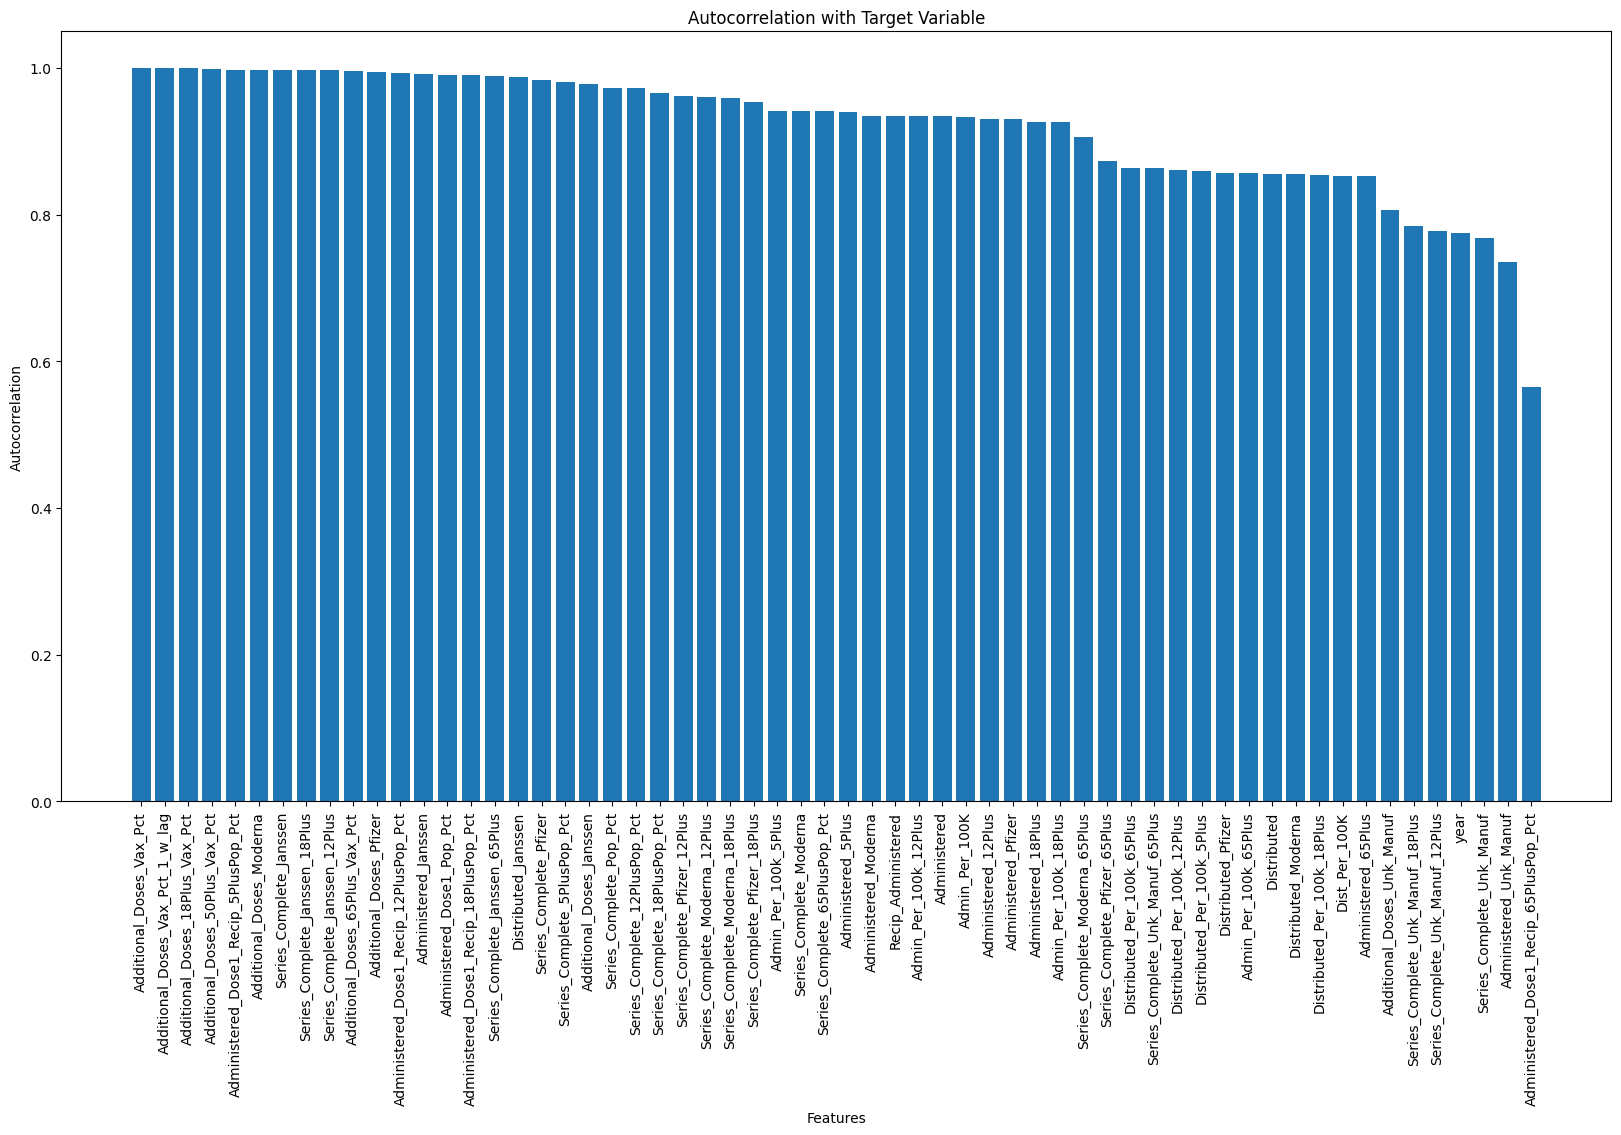

In [17]:
# Calculate autocorrelation with the target variable
target_autocorr = data[selected_features].corr()[pred_var]

# Sort autocorrelation values in descending order
sorted_autocorr = target_autocorr.sort_values(ascending=False)

# Plot autocorrelation with vertical labels
plt.figure(figsize=(20, 10))
plt.bar(sorted_autocorr.index, sorted_autocorr.values)
plt.title('Autocorrelation with Target Variable')
plt.xlabel('Features')
plt.ylabel('Autocorrelation')
plt.xticks(rotation='vertical')  # Rotate x-axis labels
plt.show()


On the subsetted data comprising 59 variables, I incorporated lag values of 1, 2, and 3 weeks for each time series variable. The determination of these lag values was informed by prior data exploration, during which I identified that the data exhibits the strongest correlation with values closest in date proximity.

In [158]:
# selected variables
df = data[selected_features_pred]
df = df.set_index('Date')

def process(df,lags=[1]):
    ret=df[[pred_var]]
    for lag in lags:
        lagdf = df.shift(lag)
        lagdf.columns=[f'lag{lag}_' + str(col) for col in lagdf.columns]
        ret=pd.concat([ret, lagdf], axis=1)
    return ret.fillna(0)
data=process(df, lags=[1,2,3])

# Check for duplicate columns
duplicates = data.columns[data.columns.duplicated()]

# Remove duplicate columns
data = data.loc[:, ~data.columns.duplicated()]

In [161]:
# Split the data into test and train

split_date = int(len(data) * 0.8)
data = data.sort_values(by ='Date',ascending=True)
train_data = data.iloc[:split_date]
test_data = data.iloc[split_date:]

# base model

I initially constructed a base XGBoost model with default parameters to assess its performance on my dataset. Similar to my approach with other models, I divided the data into an 80/20 train-test split. To evaluate the model's performance, I examined the root mean squared error (RMSE) on both the test and train sets, in addition to analyzing the residuals.

In [142]:
def train_and_evaluate_xgboost(train_data, test_data, params):
    # Extract features and target variables
    X_train, y_train = train_data.drop(pred_var, axis=1), train_data[pred_var]
    X_test, y_test = test_data.drop(pred_var, axis=1), test_data[pred_var]

    # Convert the data into DMatrix format (XGBoost's internal data structure)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    # Train the XGBoost model
    num_rounds = 100  # Number of boosting rounds (you can adjust this parameter)
    model = xgb.train(params, dtrain, num_rounds)

    feature_importance = model.get_fscore()  # Alternative: model.get_booster().get_score()
    feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

    # Make predictions on the training set
    y_train_pred = model.predict(dtrain)

    # Make predictions on the test set
    y_test_pred = model.predict(dtest)

    # Evaluate the model on training set
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)

    # Evaluate the model on test set
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

    return train_rmse, test_rmse, feature_importance, y_test_pred


In [ ]:
# base model

In [143]:
# Set XGBoost parameters
params = {
        'objective': 'reg:squarederror',  # Regression task with mean squared error loss
        'eval_metric': 'rmse'  # Root Mean Squared Error as the evaluation metric
    }

train_rmse, test_rmse, feature_importance, y_test_pred = train_and_evaluate_xgboost(train_data, test_data, params)

print(f'Training RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')


Training RMSE: 0.0006804057703807276
Test RMSE: 0.01163079796121676


## Tuning Hyperparameters with GridSearch

Based on the performance of the base model I tunned the hyperparamters with gird search to mitigate overfitting and enhance model generalization. The base model, with a training RMSE of 0.0006 and a test RMSE of 0.011, demonstrates a risk of overfitting, as the model performs exceptionally well on the training set but struggles to generalize to unseen data. Grid search systematically explores various combinations of hyperparameter values, such as learning rate, tree depth, and regularization parameters, seeking the configuration that minimizes overfitting and yields the optimal model performance. By tuning these hyperparameters, my aim was to balance between model complexity and generalization, ensuring that the model learns meaningful patterns without fitting noise. This iterative process not only helps in achieving better predictive accuracy on unseen data but also fosters a more robust and reliable model that can be confidently deployed in real-world scenarios. My goal was to improve the model's ability to capture underlying patterns in the data while avoiding the pitfalls of overfitting observed in the initial model.

XGBoost model has several key parameters that influence its behavior during training. Here's a concise description of some of the most important ones:

1. **n_estimators:**
   - *Description:* Number of boosting rounds or trees to build.
   - *Impact:* Higher values can lead to a more complex model but may increase the risk of overfitting.

2. **learning_rate:**
   - *Description:* Step size shrinkage during each boosting round.
   - *Impact:* Lower values make the model more robust but may require more boosting rounds.

3. **max_depth:**
   - *Description:* Maximum depth of each decision tree.
   - *Impact:* Controls the complexity of individual trees; higher values can lead to overfitting.

4. **subsample:**
   - *Description:* Fraction of samples used for each boosting round.
   - *Impact:* Controls randomness; values less than 1.0 can prevent overfitting.

5. **colsample_bytree:**
   - *Description:* Fraction of features used for each boosting round.
   - *Impact:* Controls feature randomness; values less than 1.0 can prevent overfitting.

6. **gamma:**
   - *Description:* Minimum loss reduction required to make a further partition on a leaf node.
   - *Impact:* Regularizes the model by pruning tree branches.

7. **reg_alpha and reg_lambda:**
   - *Description:* L1 and L2 regularization terms on weights.
   - *Impact:* Control regularization strength to avoid overfitting.

8. **min_child_weight:**
   - *Description:* Minimum sum of instance weight needed in a child.
   - *Impact:* Controls the conservatism of the algorithm.

These parameters collectively govern the trade-off between model complexity and generalization performance.
For my model I focused on tunning the following:

**max_depth**

**min_child_weight**

**subsample**

**colsample_bytree**

**eta**

**n_estimators**

**learning_rate**

**reg_alpha**

**reg_lambda**

First I performed a coarse random search.

In [182]:
# corse grid search
# tune hyperparams

X_train, y_train = train_data.drop(pred_var, axis=1), train_data[pred_var]
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define the XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

# Define the parameter grid to search
param_grid = {
    'max_depth': [1,2,3, 5, 7],
    'min_child_weight': [0.5,1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'eta': [0.01, 0.1, 0.2],
    'n_estimators': [10,25, 50, 100,150],
    'learning_rate': [0.001, 0.01, 0.05],
    'reg_alpha': np.logspace(-5, 1, 5),
    'reg_lambda': np.logspace(-5, 1, 5)
}

# Create an XGBoost regressor
xg_reg = xgb.XGBRegressor(**params)

# Define mean squared error as the scoring metric
scorer = make_scorer(mean_squared_error, greater_is_better=False)

grid_search = RandomizedSearchCV(
    estimator=xg_reg,
    param_distributions=param_grid,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1,
    random_state=42
)


# Perform grid search to find the best hyperparameters
grid_result = grid_search.fit(X_train, y_train)

# Print the best parameters and corresponding RMSE
print("Best Parameters: ", grid_result.best_params_)
print("Best RMSE: ", np.sqrt(-grid_result.best_score_))

# Get the best model from the grid search
best_model = grid_result.best_estimator_

# You can use this best_model for predictions on the test set
# Assuming you have your test_data DataFrame
X_test, y_test = test_data.drop(pred_var, axis=1), test_data[pred_var]
dtest = xgb.DMatrix(X_test, label=y_test)

# Make predictions on the test set
y_test_pred = best_model.predict(X_test)
y_train_pred = best_model.predict(X_train)
# Evaluate the best model on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'Train RMSE with Best Model: {train_rmse}')
print(f'Test RMSE with Best Model: {test_rmse}')


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters:  {'subsample': 1.0, 'reg_lambda': 0.00031622776601683794, 'reg_alpha': 0.00031622776601683794, 'n_estimators': 150, 'min_child_weight': 0.5, 'max_depth': 5, 'learning_rate': 0.05, 'eta': 0.2, 'colsample_bytree': 0.8}
Best RMSE:  0.033807120914592634
Train RMSE with Best Model: 0.00030878794383489016
Test RMSE with Best Model: 0.01434289491729221


Based on the first random search I changed the range for some hyperparameters and tunned the model again.

Training RMSE: 0.00030878794383489016
Test RMSE: 0.01434289491729221


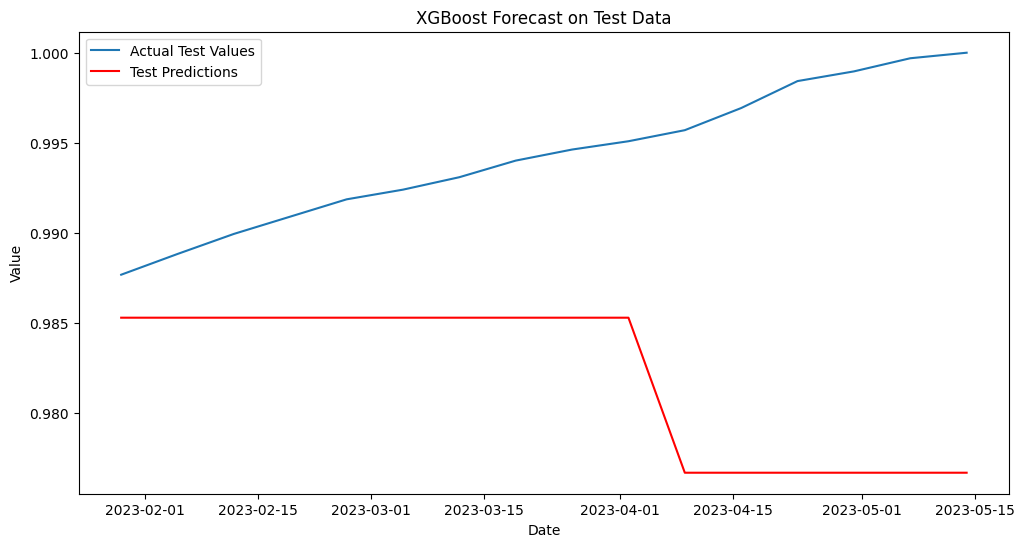

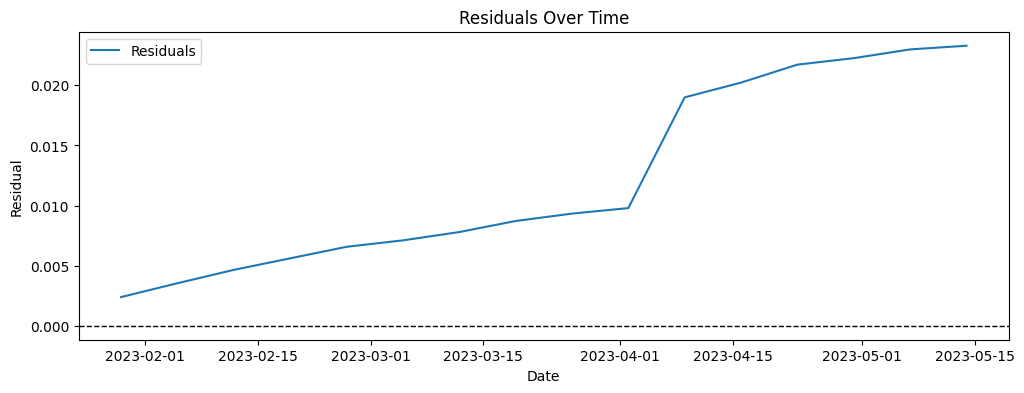

<Figure size 1000x800 with 0 Axes>

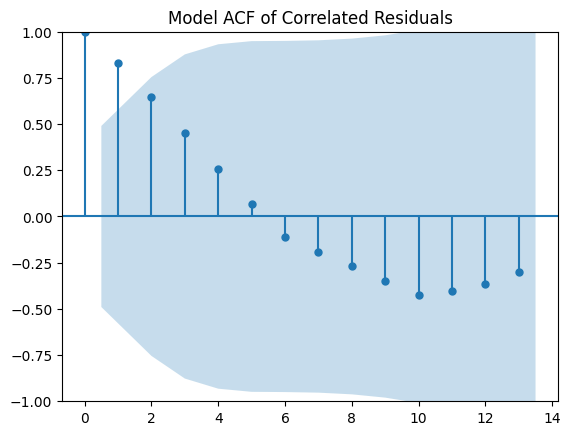

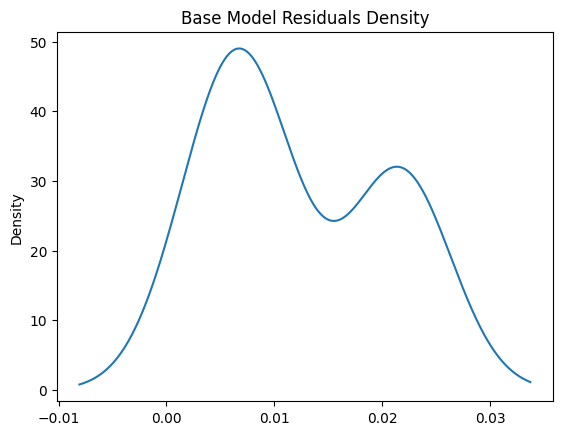

In [183]:
def plot_forecast_and_intervals(predicted_df):
    plt.figure(figsize=(12, 6))
    plt.plot(predicted_df.ds, predicted_df.ytrue, label='Actual Test Values')
    plt.plot(predicted_df.ds, predicted_df.yhat, label='Test Predictions', color='red')
    plt.title('XGBoost Forecast on Test Data')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

def plot_residuals(predicted_df):
    plt.figure(figsize=(12, 4))
    plt.plot(predicted_df.ds, predicted_df.residuals, label='Residuals')
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.title('Residuals Over Time')
    plt.xlabel('Date')
    plt.ylabel('Residual')
    plt.legend()
    plt.show()

def plot_residual_acf(predicted_df):
    plt.figure(figsize=(10, 8))
    acf_original = plot_acf(predicted_df.residuals)
    plt.title("Model ACF of Correlated Residuals")
    plt.show()

def plot_residual_density(predicted_df):
    predicted_df.residuals.plot(kind='kde', title='Base Model Residuals Density')
    plt.show()

print(f'Training RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

result_df = pd.DataFrame({'True Values': y_test, 'Predicted Values': y_test_pred}, index=test_data.index)
result_df['residuals'] = result_df['True Values'] - result_df['Predicted Values']
result_df = result_df.reset_index()
result_df.columns = ['ds','ytrue','yhat','residuals']
# Plot the forecast and intervals
plot_forecast_and_intervals(result_df)

# Plot residuals over time
plot_residuals(result_df)

# Plot residual ACF
plot_residual_acf(result_df)

# Plot residual density
plot_residual_density(result_df)

In [187]:
# feature selection
# Set XGBoost parameters
params = grid_result.best_params_

train_rmse, test_rmse, feature_importance, y_test_pred = train_and_evaluate_xgboost(train_data, test_data, params)

feature_importance

[('lag1_Distributed', 1214.0),
 ('lag1_Distributed_Janssen', 183.0),
 ('lag1_Distributed_Moderna', 167.0),
 ('lag1_Additional_Doses_Unk_Manuf', 62.0),
 ('lag1_Distributed_Pfizer', 39.0),
 ('lag1_Administered', 33.0),
 ('lag1_Distributed_Per_100k_65Plus', 7.0),
 ('lag1_Administered_5Plus', 5.0),
 ('lag1_Dist_Per_100K', 2.0),
 ('lag1_Distributed_Per_100k_5Plus', 1.0)]

Analyze tuned hyperparamter model.

Since XGBoost does not rely on time trends, unlike the previous models. It is not necessary to group the data. I wanted to develop a second XGBoost model to investigate if the grouped or ungrouped model has better performance.

Ungrouped Data

In [242]:
df = pd.read_csv('df_post_eda.csv')

# group data by Date
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Select only numerical columns
numerical_columns = df.select_dtypes(include=['number'])

# Apply Min-Max scaling only to numerical columns
scaler = MinMaxScaler(feature_range=(0, 1))
df[numerical_columns.columns] = scaler.fit_transform(numerical_columns)

data = df.sort_values(by ='Date',ascending=True)
data = data.drop('Additional_Doses_Vax_Pct_1_w_lag', axis =1)

In [243]:
def process(df, lags=[1], categorical_columns=[]):
    ret = df[[pred_var]]

    for lag in lags:
        lagdf = df.shift(lag)

        # Exclude categorical columns from lag operation
        numerical_lagdf = lagdf.drop(categorical_columns, axis=1, errors='ignore')

        numerical_lagdf.columns = [f'lag{lag}_' + str(col) for col in numerical_lagdf.columns]
        ret = pd.concat([ret, numerical_lagdf], axis=1)

    return ret.fillna(0)

# Example usage
data = process(data, lags=[1, 2, 3], categorical_columns=['lag1_Location', 'lag1_day_of_week', 'lag1_season'])

# Split data into test and train

# # Check for duplicate columns
duplicates = data.columns[data.columns.duplicated()]

# # Remove duplicate columns
data = data.loc[:, ~data.columns.duplicated()]


In [244]:
df = data.copy()
df = df.drop('Additional_Doses_Vax_Pct', axis = 1)
# Exclude 'date' column from correlation calculation
numeric_columns = df.select_dtypes(include=['float64']).columns
correlations = df[numeric_columns].apply(lambda x: spearmanr(x, data[pred_var]).correlation)

# Rank features based on absolute correlation values
ranked_features = correlations.abs().sort_values(ascending=False)

# Filter columns with correlation >= 0.3
selected_features = correlations[correlations.abs() >= 0.4].index.tolist()
print("Selected Features:", selected_features)
selected_features_pred = selected_features + [pred_var]

Selected Features: ['lag1_Dist_Per_100K', 'lag1_Distributed_Per_100k_5Plus', 'lag1_Distributed_Per_100k_12Plus', 'lag1_Distributed_Per_100k_18Plus', 'lag1_year', 'lag2_Dist_Per_100K', 'lag2_Distributed_Per_100k_5Plus', 'lag2_Distributed_Per_100k_12Plus', 'lag2_Distributed_Per_100k_18Plus', 'lag2_year', 'lag3_Dist_Per_100K', 'lag3_Distributed_Per_100k_12Plus', 'lag3_Distributed_Per_100k_18Plus', 'lag3_year']


In [239]:
len(selected_features)

14

In [245]:
#forecast_start_dt = date(2023,1,29)
split_date = pd.to_datetime('2023-01-29')
data_s = data[selected_features_pred]
# Split the data based on the date
train_data = data_s[data_s.index < split_date]
test_data = data_s[data_s.index >= split_date]

Baseline Model

In [246]:
# Set XGBoost parameters
params = {
        'objective': 'reg:squarederror',  # Regression task with mean squared error loss
        'eval_metric': 'rmse'  # Root Mean Squared Error as the evaluation metric
    }

train_rmse, test_rmse, feature_importance, y_test_pred = train_and_evaluate_xgboost(train_data, test_data, params)

print(f'Training RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Training RMSE: 0.05864995455892582
Test RMSE: 0.14283917444433014


Tunning Hyperparams

In [247]:
# corse grid search
# tune hyperparams

X_train, y_train = train_data.drop(pred_var, axis=1), train_data[pred_var]
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define the XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

# Define the parameter grid to search
param_grid = {
    'max_depth': [1,2,3, 5, 7],
    'min_child_weight': [0.5,1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'eta': [0.01, 0.1, 0.2],
    'n_estimators': [10,25, 50, 100,150],
    'learning_rate': [0.001, 0.01, 0.05],
    'reg_alpha': np.logspace(-5, 1, 5),
    'reg_lambda': np.logspace(-5, 1, 5)
}

# Create an XGBoost regressor
xg_reg = xgb.XGBRegressor(**params)

# Define mean squared error as the scoring metric
scorer = make_scorer(mean_squared_error, greater_is_better=False)

grid_search = RandomizedSearchCV(
    estimator=xg_reg,
    param_distributions=param_grid,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1,
    random_state=42
)


# Perform grid search to find the best hyperparameters
grid_result = grid_search.fit(X_train, y_train)

# Print the best parameters and corresponding RMSE
print("Best Parameters: ", grid_result.best_params_)
print("Best RMSE: ", np.sqrt(-grid_result.best_score_))

# Get the best model from the grid search
best_model = grid_result.best_estimator_

# You can use this best_model for predictions on the test set
# Assuming you have your test_data DataFrame
X_test, y_test = test_data.drop(pred_var, axis=1), test_data[pred_var]
dtest = xgb.DMatrix(X_test, label=y_test)

# Make predictions on the test set
y_test_pred = best_model.predict(X_test)
y_train_pred = best_model.predict(X_train)
# Evaluate the best model on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'Train RMSE with Best Model: {train_rmse}')
print(f'Test RMSE with Best Model: {test_rmse}')


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters:  {'subsample': 0.9, 'reg_lambda': 0.01, 'reg_alpha': 1e-05, 'n_estimators': 150, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'eta': 0.2, 'colsample_bytree': 0.9}
Best RMSE:  0.138138401510584
Train RMSE with Best Model: 0.13014245243339173
Test RMSE with Best Model: 0.12561431319631383


Training RMSE: 0.13014245243339173
Test RMSE: 0.12561431319631383


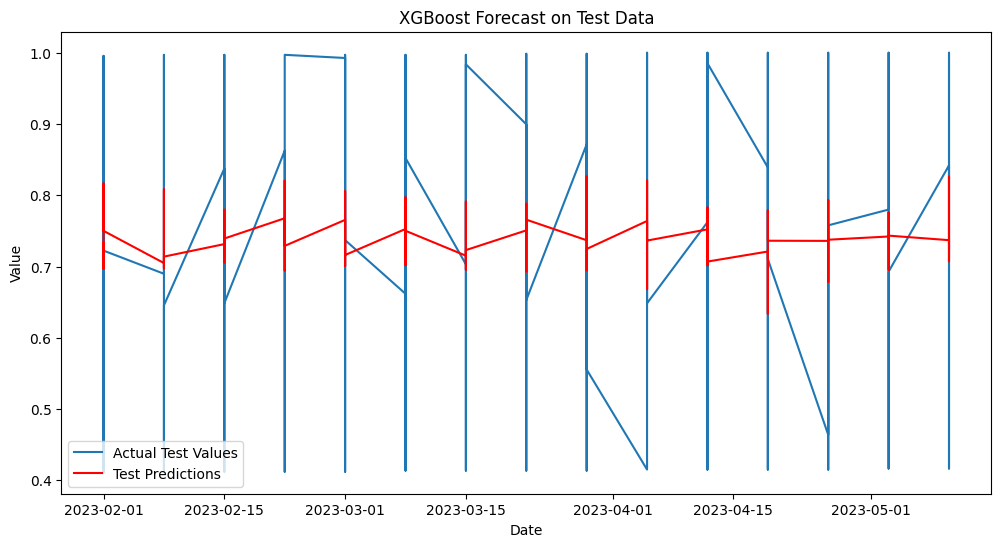

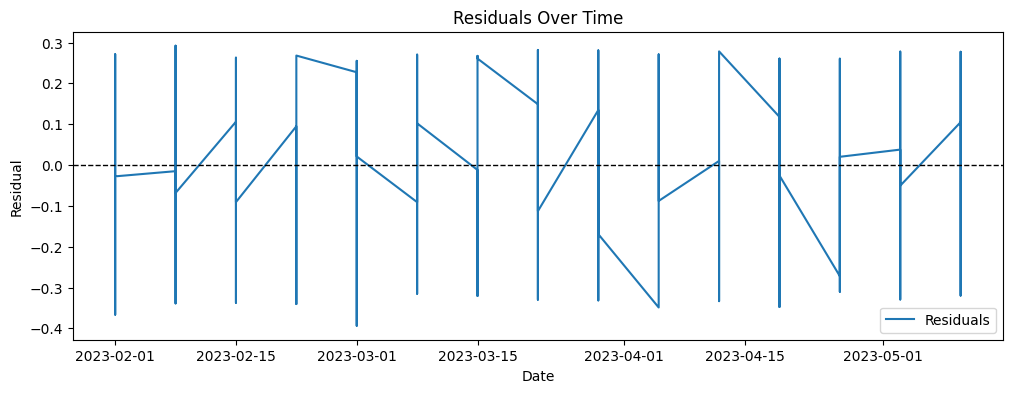

<Figure size 1000x800 with 0 Axes>

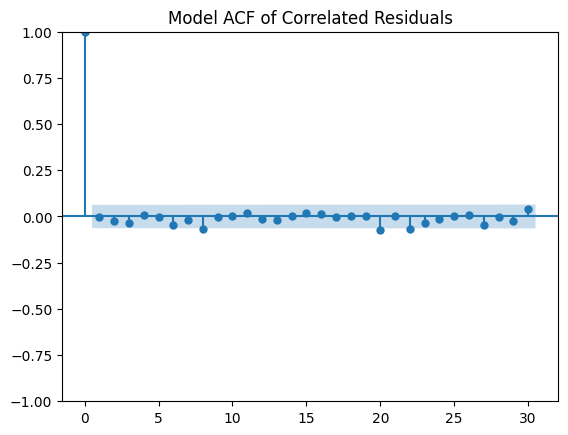

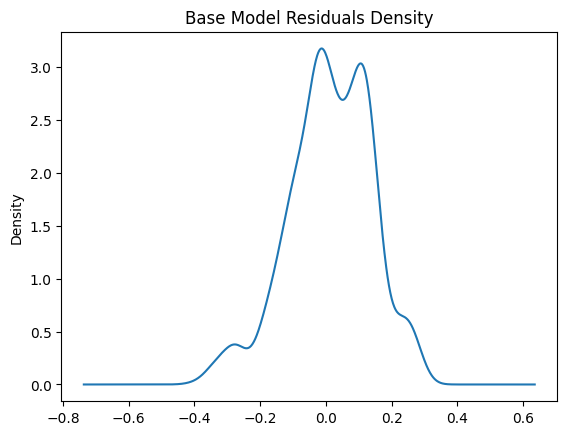

In [248]:
print(f'Training RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

result_df = pd.DataFrame({'True Values': y_test, 'Predicted Values': y_test_pred}, index=test_data.index)
result_df['residuals'] = result_df['True Values'] - result_df['Predicted Values']
result_df = result_df.reset_index()
result_df.columns = ['ds','ytrue','yhat','residuals']
# Plot the forecast and intervals
plot_forecast_and_intervals(result_df)

# Plot residuals over time
plot_residuals(result_df)

# Plot residual ACF
plot_residual_acf(result_df)

# Plot residual density
plot_residual_density(result_df)

In [250]:
# feature selection
params = grid_result.best_params_

train_rmse, test_rmse, feature_importance, y_test_pred = train_and_evaluate_xgboost(train_data, test_data, params)

feature_importance

[('lag1_Distributed_Per_100k_18Plus', 106.0),
 ('lag2_Distributed_Per_100k_18Plus', 104.0),
 ('lag3_Distributed_Per_100k_18Plus', 78.0),
 ('lag3_Dist_Per_100K', 69.0),
 ('lag2_Dist_Per_100K', 58.0),
 ('lag1_Dist_Per_100K', 50.0),
 ('lag3_Distributed_Per_100k_12Plus', 48.0),
 ('lag1_Distributed_Per_100k_12Plus', 46.0),
 ('lag2_year', 40.0),
 ('lag2_Distributed_Per_100k_5Plus', 32.0),
 ('lag1_Distributed_Per_100k_5Plus', 29.0),
 ('lag1_year', 18.0),
 ('lag2_Distributed_Per_100k_12Plus', 18.0),
 ('lag3_year', 2.0)]